# An Agent-Based Model for Codex

-By Juan Pablo Madrigal-Cianci


## Introduction

In these short notes we present a simple Agent-Based Model (ABM) to simulate Codex's economy. In particular, we will propose a simple model to simulate how *Clients* interact with *Providers*, and will then proceed to discuss how to simulate potential issues that can arise in such a simple economy. For context, *Codex is a decentralized protocol and marketplace for storage provision. 

Clients post storage contracts with fixed size, price, duration, and requested collateral. Storage providers compete for contracts.* The model is *probabilistic in nature*, i.e., it is able to capture some parameter uncertainty, as I believe that ABMs should account for several sources of uncertainty, and be used inside a Monte Carlo simulation to better understand the effects of such uncertainty.

**Requirements** This notebook is rather lightweight in its dependencies, and only requires very minimal (and standard!) libraries, namely `numpy` and `matplotlib`. This was done with simplicity in mind. 




In [7]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np

Throughout this notebook, we will make some assumptions in, e.g., the average amount of storage required per deal, the price per contract, the amount of demand, etc. These assumptions are made in the absence of further data, and can easily be revisited and improved upon once data is available.  We will assume that clients expect to pay for storage in some CODX token. Furthermore, **for simplicity, our model only focuses on the deal making and matching part, and will not address the proof of storage and slashing mechanisms.**|

## Client class

The `Client` class represents individuals or entities seeking to secure storage contracts within the marketplace. Each client is characterized by the following attributes:

- `contract_id`: A unique identifier for the storage contract proposed by the client.
- `size`: The amount of storage required for the contract, typically measured in gigabytes (GB).
- `price`: The price the client is willing to pay for the storage, expressed in CODX tokens or another cryptocurrency.
- `duration`: The length of time for which the storage is required, measured in days.
- `collateral`: The amount of collateral (in CODX tokens or another cryptocurrency) that the client is willing to put up to secure the contract.

Clients are generated dynamically based on a *demand factor*, with their attributes randomized within specified ranges to simulate a diverse range of needs and willingness to pay. The code for such a class is rather simple and is shown below.


In [8]:
class Client:
    '''
    Creates the cient class

    '''
    def __init__(self, contract_id: int, size: int, price: float, duration: int, collateral: float):
        self.contract_id = contract_id
        self.size = size
        self.price = price
        self.duration = duration
        self.collateral = collateral

Furthermore, we use a simple utility function to generate several `Client` agents, called `generate_clients`. This function dynamically generates a list of Client objects representing individuals or entities looking to secure storage contracts in the decentralized storage marketplace. The generation is based on various parameters that define the demand and contract preferences of clients. This function takes as inputs:

- `demand_factor (float)`: A multiplier that adjusts the number of clients generated. It represents market demand, with higher values indicating greater demand.
- `base_clients (int)`: The base number of clients to be generated before applying the demand factor. It sets the minimum scale of the simulation's client-side.
- `size_range (tuple)`: A tuple specifying the minimum and maximum storage size (in GB) that clients are seeking. Used to randomize the size attribute of each client.
- `price_range (tuple)`: A tuple indicating the minimum and maximum price (in CODX tokens or equivalent currency) clients are willing to pay for the storage. It randomizes the price attribute for each client.
- `duration_range (tuple)`: A tuple defining the minimum and maximum duration (in days) for which clients need the storage. This range randomizes the duration attribute of client contracts.
- `collateral_range (tuple)`: A tuple specifying the minimum and maximum amount of collateral (in CODX tokens or equivalent currency) that clients are willing to put up for the contract. It randomizes the collateral attribute of each client.

And returns  `List[Client]`; A list of `Client` objects, each initialized with randomly generated attributes (contract_id, size, price, duration, collateral) based on the input parameters. This list represents the population of clients in the marketplace simulation, each with a unique contract proposition. instantiating them with some parameters. Notice that in our model, we chose these parameters to be randomized, as to reflect different levels of need and demand within these agents. 

In [9]:
def generate_clients(demand_factor: float, base_clients: int, size_range: tuple, price_range: tuple, duration_range: tuple, collateral_range: tuple) -> List[Client]:
    '''
    Parameters:
    
    - demand_factor: A multiplier for adjusting the market demand.
    - base_clients: The base number of clients to generate before scaling by demand.
    - size_range: The range of storage sizes clients are seeking (min, max in GB).
    - price_range: The range of prices clients are willing to pay (min, max in CODX tokens).
    - duration_range: The range of contract durations clients are interested in (min, max in days).
    - collateral_range: The range of collateral amounts clients can provide (min, max in CODX tokens).

    Returns:
    - A list of Client objects with randomized attributes based on the input ranges.
    """

    '''
    num_clients = int(base_clients * demand_factor)
    clients = []
    for i in range(num_clients):
        contract_id = i
        size = np.random.randint(*size_range)
        price = np.random.uniform(*price_range)
        duration = np.random.randint(*duration_range)
        collateral = np.random.uniform(*collateral_range)
        clients.append(Client(contract_id, size, price, duration, collateral))
    return clients

Notice that here we have chosen to model the uncertainty in the client side as uniform distributions within some given range. Once again, this choice is done purely for demonstration purpuses and can easily be adjusted for some arbitrary, data-driven distribution (or process) once data bcomes available. 

## Provider class 

The Provider class represents storage providers in the marketplace, each equipped with specific attributes that define their capacity to fulfill storage contracts:

- `provider_id`: A unique identifier for the provider.
-`capacity`: The total storage capacity that the provider is willing to offer, measured in GB.
-`price_threshold`: The minimum price per unit of storage that the provider is willing to accept.
-`max_duration`: The maximum duration of a contract that the provider is willing to accept.
-`collateral_available`: The amount of collateral the provider can put up to secure contracts.

Providers decide on whether to accept contracts based on these attributes. The `decide_on_contract` method determines if a proposed client contract meets the provider's criteria regarding price, duration, and required collateral. Upon accepting a contract, the provider's available collateral is reduced by the amount tied to the accepted contract. The code for this class is shown below: 


In [12]:
class Slot:
    def __init__(self, slot_id: int, capacity: int, price_threshold: float, max_duration: int, collateral_available: float):
        self.slot_id = slot_id
        self.capacity = capacity
        self.price_threshold = price_threshold
        self.max_duration = max_duration
        self.collateral_available = collateral_available

    def decide_on_contract(self, contract: Client) -> bool:
        '''Decides whether or not to take a contract, it should pay more than the minimum they're willing to receive and they shjould have enough collateral'''

        decision=contract.price >= self.price_threshold and contract.duration <= self.max_duration and self.collateral_available >=contract.collateral

        if decision==True:
            self.collateral_available=self.collateral_available-contract.collateral
        
        return decision

class Provider:
    def __init__(self, provider_id: int, until:int, slots: List[Slot]):
        self.provider_id = provider_id
        self.until = until
        self.slots = slots

Similarly as before, we create an auxilliary function `generate_providers` to help us instantiate each provider. This function dynamically generates a list of Provider objects representing entities offering storage capacities within the decentralized storage marketplace. The generation is based on specified parameters that define the supply side of the marketplace, including the storage capacity, price thresholds, and contractual preferences of providers. It takes as inputs:

- `num_providers (int)`: The number of provider entities to generate. This determines the scale of the supply side in the marketplace simulation.
- `capacity_range (tuple)`: A tuple specifying the minimum and maximum storage capacity (in GB) that providers are offering. It randomizes the capacity attribute of each provider.
- `price_threshold (tuple)`: A tuple indicating the minimum and maximum price threshold (in CODX tokens or equivalent currency) below which providers are not willing to accept contracts. It randomizes the price_threshold (or min_price) attribute for each provider.
- `duration_range (tuple)`: A tuple defining the minimum and maximum duration (in days) of contracts that providers are willing to fulfill. This range randomizes the max_duration attribute of providers.
- `collateral_range (tuple)`: A tuple specifying the minimum and maximum collateral capacity (in CODX tokens or equivalent currency) that providers can offer for securing contracts. It randomizes the collateral_capacity attribute of each provider.


and returns `List[Provider]`; A list of `Provider` objects, each initialized with randomly generated attributes (provider_id, capacity, min_price, max_duration, collateral_capacity) based on the input parameters. This list represents the population of storage providers in the marketplace simulation, each with unique capabilities and contract preferences.

In [28]:
def generate_providers(num_providers: int, capacity_range: tuple, price_threshold: tuple, duration_range: tuple, collateral_range: tuple, slots_range: tuple, until_range: tuple) -> List[Provider]:
    """
    Parameters:
    - num_providers: The number of storage providers to generate.
    - capacity_range: The range of storage capacities offered by providers (min, max in GB).
    - price_threshold: The range of minimum prices providers are willing to accept (min, max in CODX tokens).
    - duration_range: The range of maximum contract durations providers are willing to fulfill (min, max in days).
    - collateral_range: The range of collateral capacities providers can offer (min, max in CODX tokens).

    Returns:
    - A list of Provider objects with randomized attributes based on the input ranges.
    """
    providers = []
    for i in range(num_providers):
        slots = []
        provider_id = i
        num_slots = np.random.randint(*slots_range)
        until = np.random.randint(*until_range)

        for i in range(num_slots):
            slot_id = i
            capacity = np.random.randint(*capacity_range)
            min_price = np.random.uniform(*price_threshold)
            max_duration = np.random.randint(*duration_range)
            collateral_capacity = np.random.uniform(*collateral_range)
            slots.append(Slot(slot_id,capacity,min_price,max_duration,collateral_capacity))

        providers.append(Provider(provider_id, until, slots))
    return providers

Once again, we use a uniform distribution to capture the *uncertainties* associated to each provider, as all of them will have different capacities, minimum price that they're willing to store data for etc

## Bookkeeping Classes

In addition to the `Client` and `Provider` classes, we also require some mechanism to keep track of the available deals and the deals made. This is where the "Bookkeeping" classes come into play. In the simulation of the Codex decentralized marketplace, the `MarketplaceBookkeeper` and `Deal` classes play crucial roles in managing transactions between clients seeking storage contracts and providers offering storage solutions. In particular:

### MarketplaceBookkeeper Class

The MarketplaceBookkeeper class serves as the central ledger for all transactions (deals) within the marketplace. It is responsible for recording, tracking, and providing information on all deals made between clients and providers. This class ensures that every transaction is documented, allowing for analysis and auditing of marketplace activity. The key functions of this class are:

- Deal Recording: The add_deal method allows the bookkeeper to record a new deal when a match is made between a client's requirements and a provider's offerings. This method generates a unique identifier for each deal, encapsulates the deal's details in a Deal object, and adds it to the bookkeeper's ledger, and

- Information Retrieval: The get_deal_info method provides a way to retrieve detailed information about a specific deal using its unique identifier. This capability is essential for reviewing transaction details and verifying the terms of agreements made in the marketplace.

The code for this class is shown below



In [29]:
class MarketplaceBookkeeper:
    """
    This is a class to keep track of the deals made
    
    """
    def __init__(self):
        self.deals = []

    def add_deal(self, client: Client, provider: Provider, slot: Slot, size: int, price: float, duration: int, collateral: float):
        # Generate a unique deal ID based on the current number of deals
        deal_id = len(self.deals) + 1
        deal = Deal(deal_id, client, provider, slot, size, price, duration, collateral)
        self.deals.append(deal)
        return deal

    def get_deal_info(self, deal_id: int):
        for deal in self.deals:
            if deal.deal_id == deal_id:
                return f"Deal ID: {deal.deal_id}, Client ID: {deal.client.contract_id}, Provider ID: {deal.provider.provider_id}, Size: {deal.size}, Price: {deal.price}, Duration: {deal.duration}, Collateral: {deal.collateral}"
        return "Deal not found."

### Deal Class

The Deal class represents an individual transaction agreement between a client and a provider in the marketplace. The Deal class encapsulates all pertinent information about a transaction, serving as a comprehensive record of each agreement within the marketplace. It enables the tracking of contractual obligations, financial transactions, and the allocation of storage resources. Each deal captures the terms agreed upon by both parties, including the size of the storage contract, the price, the duration, and any required collateral.

Attributes

- `deal_id`: A unique identifier for the deal, facilitating easy tracking and retrieval.
- `client`: A reference to the Client object involved in the deal, linking the deal to the client's requirements.
- `provider`: A reference to the Provider object fulfilling the deal, connecting the deal to the provider's offerings.
- `size`: The amount of storage being contracted, typically measured in gigabytes or terabytes.
- `price`: The agreed-upon price for the storage contract, often specified in CODX tokens or another form of cryptocurrency.
- `duration`: The length of time for which the storage is contracted, usually in days.
- `collateral`: The amount of collateral provided to secure the deal, enhancing trust and commitment between the parties.

 The class's __repr__ method provides a human-readable representation of a deal, aiding in debugging and logging activities.

The code for this class is shown below:

In [30]:
class Deal:
    def __init__(self, deal_id: int, client: Client, provider: Provider, slot: Slot, size: int, price: float, duration: int, collateral: float):
        """
        Initialize a new deal with details about the transaction.

        Parameters:
        - deal_id (int): A unique identifier for the deal.
        - client (Client): The client object involved in the deal.
        - provider (Provider): The provider object agreeing to fulfill the deal.
        - size (int): The size of the storage contract (e.g., in GB or TB).
        - price (float): The price agreed upon for the storage contract.
        - duration (int): The duration of the contract (e.g., in days).
        - collateral (float): The collateral amount required for the deal.
        """
        self.deal_id = deal_id
        self.client = client
        self.provider = provider
        self.slot = slot
        self.size = size
        self.price = price
        self.duration = duration
        self.collateral = collateral

    def __repr__(self):
        """
        Provide a readable representation of the Deal object for debugging and logging.
        """
        return (f"Deal(ID: {self.deal_id}, Client ID: {self.client.contract_id}, Provider ID: {self.provider.provider_id}, Slot ID: {self.slot.slot_id}"
                f"Size: {self.size}GB, Price: {self.price} CODX, Duration: {self.duration} days, "
                f"Collateral: {self.collateral} CODX)")


## Modeling arrivals

In our model, we begin with a small number of providers and clients, and then, over time, simulate the arrival process of these agents to the network using a [Poisson Process](https://en.wikipedia.org/wiki/Poisson_point_process). Loosely speaking, under this model, we assume that clients or providers join the network at random times, and that on average, there are $\lambda_\text{clients}$ and $\lambda_\text{providers}$ new clients and providers joining per day. Once again, we choose this model to reflect the fact that providers and clients do not join the network at set times, but rather at random times. A depiction of the arrival process is shown below. 

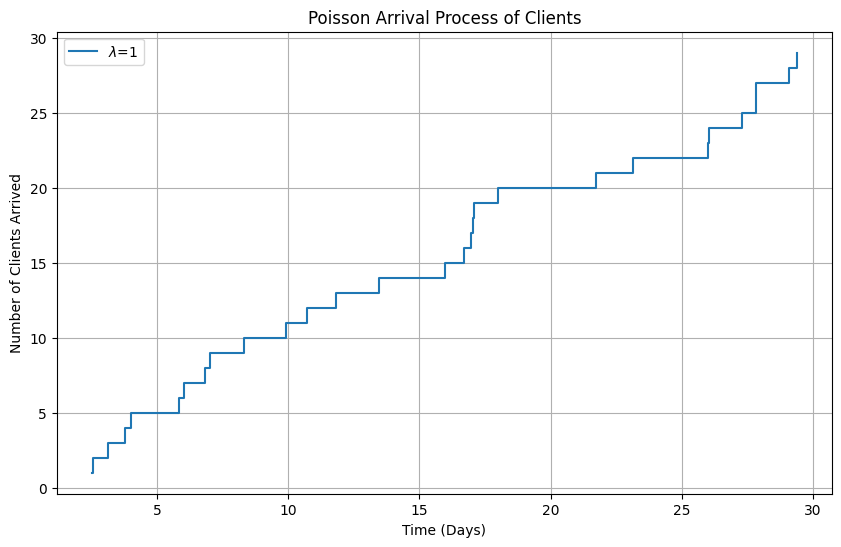

Number of arrivals: 29
Arrival times: [2.5160411572913395, 2.562883864628878, 3.10593437756273, 3.752226353638486, 3.992178221870576, 5.814433354486766, 6.022307063514577, 6.8077269835736915, 6.992540491374434, 8.306794566829932, 9.917274583952752, 10.699049592218516, 11.805563343495377, 13.45588669014389, 15.980351676923087, 16.711524011971676, 16.96285352955512, 17.03225542984014, 17.083501014729862, 17.986212206990906, 21.730509244722565, 23.146468173044614, 26.014951706961362, 26.040853071294833, 27.317597892082574, 27.83333870906888, 27.85099430870606, 29.096141699305107, 29.384099003766256]


In [16]:
def simulate_poisson_arrivals(lambda_rate, total_time):
    """
    Simulate a Poisson arrival process.

    Parameters:
    - lambda_rate: The average rate of arrivals per unit time (e.g., deals per day).
    - total_time: The total time over which to simulate the arrivals.

    Returns:
    - A list of arrival times within the simulation period.
    """
    arrival_times = []
    current_time = 0
    
    while current_time < total_time:
        # Generate the next inter-arrival time
        inter_arrival_time = np.random.exponential(1 / lambda_rate)
        current_time += inter_arrival_time
        if current_time < total_time:
            arrival_times.append(current_time)
    
    return arrival_times


# Example: Simulate deal arrivals with an average of 5 deals per day over a period of 30 days
lambda_rate = 1
total_time = 30 # Days
arrival_times = simulate_poisson_arrivals(lambda_rate, total_time)

# Plotting the step function for arrival times
plt.figure(figsize=(10, 6))
plt.step(arrival_times, range(1, len(arrival_times) + 1), where='post',label=fr'$\lambda$={lambda_rate}')
plt.xlabel('Time (Days)')
plt.ylabel('Number of Clients Arrived')
plt.title('Poisson Arrival Process of Clients')
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of arrivals: {len(arrival_times)}")
print(f"Arrival times: {arrival_times}")

A useful property of the Poisson process is that it's *memoryless*, (c.f. [Kroese et. Al. 2011](https://www.wiley.com/en-us/Handbook+of+Monte+Carlo+Methods-p-9780470177938)) i.e., an arrival at time $t_1$ does not depend of the arrival that occured at $t_0$, $t_0<t_1$. This property, together with the defition of the Poisson process, can be used to show that the time $\Delta_t$ between any two arrivals of a Poisson process with rate $\lambda$ is a random variable following an  $\mathsf{Exponential}(\lambda)$ distribution. This will be useful when designing our time-marching scheme, since the time $\Delta_t$ between any two actions in our ABM can also be sampled from such a distribution.

## Putting it together


### Initialization
We are now ready to put everything together. The main structure of the simulation loop is designed to model the dynamic interactions between clients seeking storage solutions and providers offering storage capacities over a predetermined simulation period. This loop is the heartbeat of the simulation, where the marketplace's supply and demand mechanics play out, and deals are made or left unserviced based on the availability and preferences of participants. 

The code begins by initializing some simulation parameters. Notice that tuning these parameters will be of importance when investigating things such as supply/demand imbalances, for example. 

In [31]:
# Initialize simulation parameters
demand_factor = 1.0  # Initial demand factor for the marketplace
num_providers = 100  # Number of storage providers in the marketplace

# Provider capacity and contract terms ranges
capacity_range_providers = (100, 1000)  # Provider capacity range in GB
duration_range_providers = (30, 365)  # Contract duration range in days
collateral_range_providers = (0.1, 10.0)  # Collateral range in CODX tokens
price_threshold_providers = (0.5,2)  # Minimum acceptable price for providers, in CODX tokens
slots_range = (1,10) #Number of slots
until_range = (1,3)
# Client parameters
capacity_range_clients = (100, 1000)  # client capacity range in GB
duration_range_clients = (30, 365)  # Contract duration range in days
collateral_range_clients = (0.1, 5)  # Collateral range in CODX tokens
price_threshold_clients = (0.5,3)  # Minimum acceptable price for clients, in CODX tokens

# Client arrival parameters
lambda_rate_client = 5  # Average number of clients arriving per day
lambda_rate_provider=1/3  # Average number of providers arriving per day
total_time = 30  # Total simulation time in days


Once this is done, we instantiate the first batch of storage providers, and initialize some relevant parameters:

In [38]:
# Generate initial set of providers
providers = generate_providers(num_providers, 
                               capacity_range_providers,
                               price_threshold_providers,
                               duration_range_providers,
                               collateral_range_providers,
                               slots_range,
                               until_range)

# Initialize the marketplace bookkeeper for tracking deals
bookkeeper = MarketplaceBookkeeper()


# Initialize variables for tracking simulation outcomes
unserviced_deals = 0
deals_over_time = []
collateral_over_time = []
deals_per_provider = {provider.provider_id: 0 for provider in providers}  # Deal count per provider

available_space_over_time = []
unserviced_deals_list = []

# Calculate initial total capacity
total_capacity = sum(slot.capacity for provider in providers for slot in provider.slots)
available_space_over_time.append(total_capacity)


### Time marching

With this, we are ready to begin our time-marching scheme. The simulation operates on a continuous timeline, advancing time based on the arrival of either a client or a provider, determined by exponential distributions representing Poisson processes. This method allows for a realistic representation of random arrivals within the marketplace.

- Time Increment: The loop increments time (`time`) by the smaller of two intervals: `t_client` or `t_provider`, which represent the time until the next client or provider arrives, respectively. This approach ensures that the simulation accurately reflects the asynchronous nature of arrivals in the marketplace. Recall that there 

$$t_\text{client}\sim \mathsf{Exponential}(\lambda_\text{client})$$
$$t_\text{provider}\sim \mathsf{Exponential}(\lambda_\text{provider})$$

#### Client Arrival and Deal Matching
Upon the arrival of a client (when `t_client < t_provider`), the simulation performs several key steps:

1. Client Generation: A new client is generated with randomized attributes (size, price, duration, collateral) within specified ranges, reflecting the diverse requirements of clients in the marketplace.
2. Provider Selection: The simulation searches for an available provider that meets the client's contract requirements and has the highest available collateral. This selection process emphasizes the importance of collateral as a trust and commitment mechanism within the marketplace.
3. Deal Formation: If a suitable provider is found, a deal is formed, and its details are recorded by the MarketplaceBookkeeper. The formation of a deal represents a successful match between supply and demand, contributing to the marketplace's overall activity.

#### Provider Arrival and Potential Servicing of Unserviced Deals
When a new provider arrives (determined by `t_provider < t_client`), the simulation introduces a new entity into the marketplace with its capacity, preferences, and collateral. This new provider then has the opportunity to service previously unserviced deals, addressing unmet demand within the marketplace.

The code for the main loop is shown below:

In [24]:
# initializes simulation
time = 0

# Main simulation loop
while time < total_time:
    
    # Uses a poisson process here to decide.
    t_client=np.random.exponential(1/lambda_rate_client)
    t_provider=np.random.exponential(1/lambda_rate_provider)
    
    if t_client < t_provider: # client arrives
    
        time = time + t_client
        # Generate a single client based on the demand factor
        client = generate_clients(demand_factor,
                                  1,
                                  capacity_range_clients,
                                  price_threshold_clients, 
                                  duration_range_clients,
                                  collateral_range_clients)[0]
        
        # Select provider with the highest collateral available
        selected_provider = max(providers, key=lambda p: p.collateral_available, default=None)
        # applicable_providers = [provider for provider in providers where decide_on_contract(client) == True]
        # Attempt to create a deal between the client and selected provider
        if selected_provider and selected_provider.decide_on_contract(client):
            bookkeeper.add_deal(client, selected_provider, client.size, client.price, client.duration, client.collateral)
        else:
            
    
            
            unserviced_deals += 1  # Increment unserviced deals counter if no match is found
            unserviced_deals_list.append(client)

        # Record the total number of deals and collateral at this point in time
        deals_over_time.append(len(bookkeeper.deals))
        total_collateral = sum(deal.collateral for deal in bookkeeper.deals)
        collateral_over_time.append(total_collateral)
        
        # Update the count of deals serviced by each provider
        for deal in bookkeeper.deals:
            deals_per_provider[deal.provider.provider_id] += 1
    
    else: #provider arrives
        time=time+t_provider
        new_provider = generate_providers(1, capacity_range_providers,
                                           price_threshold_providers,
                                           duration_range_providers, 
                                           collateral_range_providers)[0]
        providers.append(new_provider) 
        total_capacity += new_provider.capacity  # Increase total capacity

        # Attempt to service previously unserviced deals
        for unserviced_client in unserviced_deals_list[:]:  # Iterate over a copy of the list
            if new_provider.decide_on_contract(unserviced_client):
                bookkeeper.add_deal(unserviced_client, new_provider, unserviced_client.size, unserviced_client.price, unserviced_client.duration, unserviced_client.collateral)
                unserviced_deals_list.remove(unserviced_client)  # Remove serviced client from the unserviced list
                deals_per_provider[new_provider.provider_id] += 1  # Update deal count for the new provider
                


    current_collateral = sum(deal.collateral for deal in bookkeeper.deals if deal.provider in providers)
    available_space_over_time.append(total_capacity - current_collateral)
  

### Monitoring
Throughout the simulation, several metrics are meticulously tracked to monitor the marketplace's health and dynamics. Once the time marching scheme is over, once can visualize several metrics of interests, such as:

- Deals Over Time: Tracks the cumulative number of deals made, offering insights into the marketplace's activity levels.
- Collateral Over Time: Monitors the total collateral committed in deals, indicative of the financial engagement and trust within the marketplace.
- Available Space Over Time: Follows the total available storage capacity over time, adjusting for new provider arrivals and storage allocated through deals. This metric is crucial for understanding supply dynamics.
These metrics, along with additional analyses like the distribution of deals per provider, are visualized after the simulation concludes, providing a comprehensive overview of the marketplace's performance and areas for potential improvement.

The code for this is shown below.

Total deals serviced: 34
Unserviced deals: 139


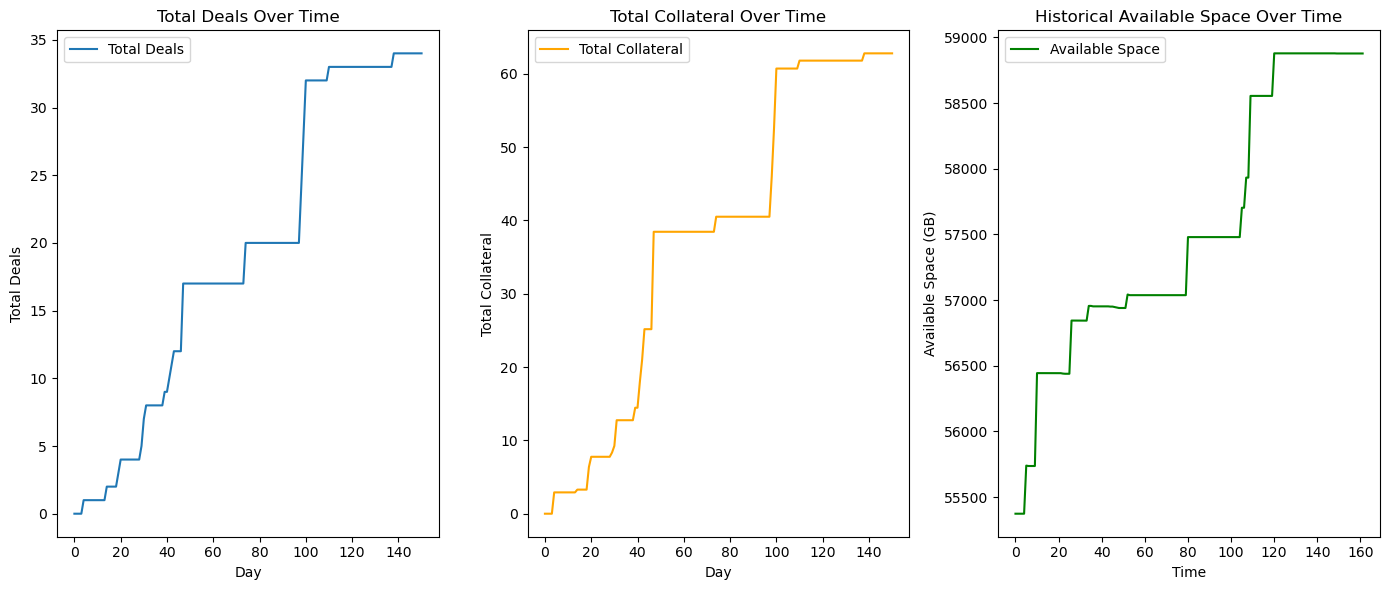

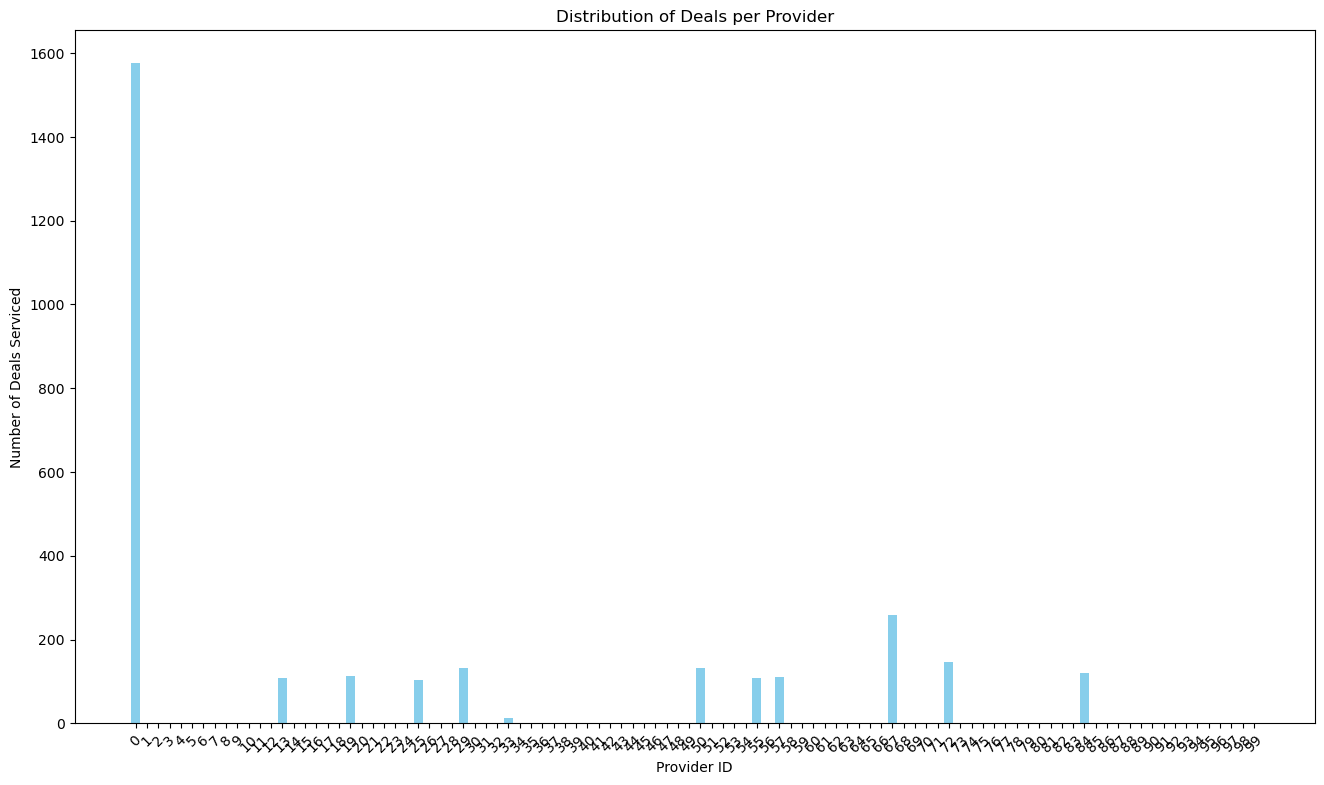

In [25]:
# Output the total number of deals serviced and unserviced deals
print(f"Total deals serviced: {len(bookkeeper.deals)}")
print(f"Unserviced deals: {unserviced_deals}")

# Plot the total number of deals and collateral over time
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(deals_over_time, label='Total Deals')
plt.xlabel('Day')
plt.ylabel('Total Deals')
plt.title('Total Deals Over Time')
plt.legend()

plt.subplot(1, 3, 2)

plt.plot(collateral_over_time, label='Total Collateral', color='orange')
plt.xlabel('Day')
plt.ylabel('Total Collateral')
plt.title('Total Collateral Over Time')
plt.legend()

plt.subplot(1, 3, 3)

plt.plot(available_space_over_time, label='Available Space', color='green')
plt.xlabel('Time')
plt.ylabel('Available Space (GB)')
plt.title('Historical Available Space Over Time')
plt.legend()
plt.tight_layout()

plt.show()


# Plot the distribution of deals per provider
plt.figure(figsize=(16, 9))
providers_ids = list(deals_per_provider.keys())
deals_counts = list(deals_per_provider.values())

plt.bar(providers_ids, deals_counts, color='skyblue')
plt.xlabel('Provider ID')
plt.ylabel('Number of Deals Serviced')
plt.title('Distribution of Deals per Provider')
plt.xticks(providers_ids, rotation=45)  # Ensure provider IDs are readable
plt.show()


Notice that one can then move the necessary levers to investigate several scenarios. For example, an imbalance of the amount supply vs. demand could be simulated by changing `capacity_range_providers` relative to `capacity_range_clients`, and or by changing $\lambda_\text{client}$ relative to $\lambda_\text{provider}$. One can furthermore, simulate temporarilly *spikes* in demand (or supply) by setting $\lambda=\lambda(t)$. Lastly, **it is important to mention** that, given the *probabilistic* nature of the simulator presented herein, it needs to be used inside a Monte Carlo inner loop so that one can quantify the effects of the underlying uncertainty (arrival times, collaterals, prices, etc) have on some given quantity of interest (number of available space, for example). While this step is rather straightforward, we decided not to implement it at this stage, for the sake fo brevity and stiking to the allocated time. However, we'd be more than happy to do so, if requested. 


## Shocks and risk mitigation. 

Lastly, in this section we address the questions: *What kind of internal and external shocks could happen, and what would be the consequences in the system (it is sufficient to provide a discussion here)? Can you think of ways of mitigating or limiting these risks?*

The simulation of the Codex decentralized protocol marketplace, by design, allows for the exploration of various dynamics between clients and providers in a storage marketplace. However, like any marketplace, it is susceptible to both internal and external shocks that can significantly impact its efficiency, fairness, and overall stability. Understanding these shocks and devising strategies to mitigate their effects are crucial for maintaining a robust marketplace. Here’s a discussion on potential shocks, consequences, and mitigation strategies:

#### Sudden Withdrawal of Major Providers

- **Scenario**: Significant providers exit the marketplace abruptly or fail to maintain their service commitments.
- **Consequences**: Reduced storage capacity leading to unmet demand, increased prices, and diminished trust in the marketplace.
- **Mitigation**: Diversify the provider base and implement redundancy to minimize reliance on any single provider. Introduce incentives for new providers to join and maintain a healthy competition within the marketplace.
- **Simulation Approach**: Model scenarios where a percentage of top providers exit the marketplace. Observe the impact on service availability, deal fulfillment rates, and price fluctuations.

#### Rapid Changes in Provider Collateral

- **Scenario**: Volatility in the CODX token value affects providers' ability to post collateral, impacting their participation and trustworthiness.
- **Consequences**: Fluctuations in marketplace liquidity and trust, potentially leading to fewer transactions.
- **Mitigation**: Establish minimum collateral requirements and create a stabilization fund to support providers during periods of significant volatility.
- **Simulation Approach**: Introduce volatility in token valuation and simulate its impact on provider participation and the number of successfully completed deals.

#### Cryptocurrency Volatility

- **Scenario**: The value of cryptocurrencies, especially CODX, experiences significant fluctuations.
- **Consequences**: Contract stability and fairness may be compromised, affecting participant confidence and willingness to engage in the marketplace.
- **Mitigation**: Incorporate stablecoin or fiat-pegged contract options for price stability. Develop hedging strategies to protect against cryptocurrency exposure.
- **Simulation Approach**: Model extreme volatility in cryptocurrency values to assess the impact on contract pricing and fulfillment.

#### Centralization Risk

- **Scenario**: Geographic or economic factors lead to a concentration of service provision, creating potential for monopolistic behavior.
- **Consequences**: A principal-agent problem and reduced marketplace competition, potentially harming efficiency and fairness.
- **Mitigation**: Incentivize geographic and economic decentralization. Consider implementing mechanisms like quadratic funding or rewards to counterbalance the influence of large entities while being mindful of Sybil attack risks.
- **Simulation Approach**: Simulate the accumulation of market power by a small number of providers and evaluate measures to encourage decentralization.

#### Inflation of Rewards

- **Scenario**: The issuance of participation rewards outpaces the locking and expenditure of tokens, risking token depreciation.
- **Consequences**: Potential token inflation, reducing its value and the purchasing power of participants.
- **Mitigation**: Implement a dynamic reward mechanism adjusted according to the marketplace's economic indicators and tokenomics model.
- **Simulation Approach**: Model varying rates of reward issuance and their long-term impact on token value and marketplace activity.


#### Unprofitable gas prices

- **Scenario**: Pressumably, providers will need to pay transaction fees when onboarding data and when proving that they are holding to such data. Extremely high gas prices are a concern here from the supply side, as it would need to adjust prices accordingly, to a point where users might not be willing to pay.
- **Consequences**: Extremely high gas prices can "eat" into their potential profits, to thge point of making the whole system unprofitable. 
- **Mitigation**: This is tricky to mitigate, as it stems from an imabalnce in demand vs. supply. This can be tackled by e.g., improving the efficiency of the protocol, or by other, more advanced techniques, such as having a multi-dimensional EIP1559 mechanism (c.f. [here](https://www.initc3.org/events/2023-06-12-ic3-blockchain-camp-2023))
- **Simulation Approach**: Include a base-fee adjusting mechanism (e.g., EIP1559) and adjust prices accordingly. Useful to understand proportion fo deals that can't be made due to gas being so unprofitable 
